# 02 Computational Representations of Biomedical Shapes

## B) Shapes of Curves

$\color{#003660}{\text{Nina Miolane - Assistant Professor}}$ @ BioShape Lab @ UCSB ECE

<center><img src="figs/02_cells.png" width=800px alt="default"/></center>
<center>Cell images obtained by fluorescence microscopy. </center>


# Outline

- **Unit 2 (Shapes): Computational Representations of Biomedical Shapes**
  - A) Shapes of landmarks
  - **B) Shapes of curves**
    - Motivation: Shape of Cancer Treatments
    - Practice: SRV Quotient Analysis
    - Theory: Geometry of SRV manifolds
    - Application: Osteoscarcoma cells
  - C) Shapes of surfaces
  - D) Deformations


## Motivation: Shape of Cancer Treatments

### Cell Shapes and Cell Functions

Each cell type has evolved in a **shape** that is best related to its function.

$\color{#047C91}{\text{Examples}}$:
- Neurons: axons and dendrites to _reach out_ to other nerve cells and help pass messages quickly. 
- Red blood cells: round shape to _move quickly_ through capillaries. 

<center><img src="figs/02_from_stem.png" width=600px alt="default"/></center>

### Cell Shapes and Cell Health

Within a given cell type, cell **shape** is related to "cell health".

$\color{#047C91}{\text{Example}}$: Irregular shapes of cancer cells.

<center><img src="figs/02_cancer_cells22.jpg" width=1000px alt="default"/></center>

### An Insider Look

$\color{#EF5645}{\text{Definition}}$: Actin is a family of proteins that form microfilaments in the cytoskeleton, and:
- play a significant role in determining a cell shape.
- participate in important cellular processes: muscle contraction, cell division, cell signaling, etc.

$\rightarrow$ cell shapes gives us insights on actin's behavior in the cell.


<center><img src="figs/02_actin.jpeg" width=400px alt="default"/></center>
<center>Human Lung Carcinoma Cells (A-549) - https://tinyurl.com/2p8axfxe</center>
<center> Cells nuclei (blue), actin cytoskeleton (green) and lipid membrane (red). </center>

### Cell Shapes and Cancer Treatments

New large-scale cell live imaging raises interest for morphological studies.

$\color{#EF5645}{\text{Question}}$: Which cancer treatments affect the actin and cytoskeleton?

<center><img src="figs/02_cells.png" width=1300px alt="default"/></center>

<center> Cells nuclei (blue), actin cytoskeleton (green) and lipid membrane (red). </center>

### Data


- **Raw:** Images of mouse osteosarcoma (bone cancer) cells from fluorescence microscopy
- **Preprocessed:** Segmentation and contour extraction
- 2 cell lines (i.e. cultures of cells): DUNN, DLM8 (more aggressive cancer)
- 3 states: 1 control group, 2 cancer treatments: Jasplakinolide (jasp) and cytochalasin D (cytd).

$\rightarrow$ $\color{#EF5645}{\text{Question}}$: Which cancer treatments lead to irregular cell shapes?

<center><img src="figs/02_curves_blueorange.png" width=700px alt="default"/></center>

 Load the Dataset.

In [1]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")
print(f"The array contained the 0th cell has shape {cells[0].shape}.")

INFO: Using numpy backend


Total number of cells : 650
The array contained the 0th cell has shape (210, 2).


In [3]:
import numpy as np
import pandas as pd

TREATMENTS = np.unique(treatments); print(TREATMENTS)
LINES = np.unique(lines); print(LINES)

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


Count how many cells are available in each cell line and each treatment group.

In [5]:
ds = {}; n_cells_arr = np.zeros((3, 2))
for i, treatment in enumerate(TREATMENTS):
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = np.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]}); n_cells_df = n_cells_df.set_index(TREATMENTS)
display(n_cells_df)

,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


Plot one cell.

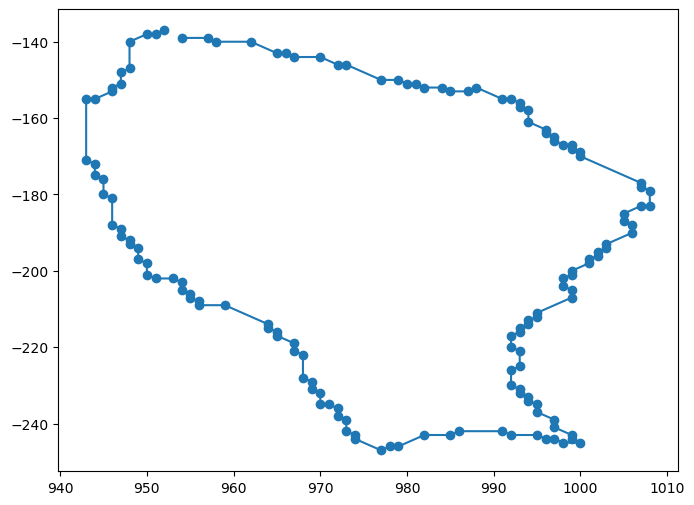

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(cells[1][:, 0], cells[1][:, 1], "C0", marker="o");

### From Shapes of Landmarks to Shapes of Curves

$\color{#EF5645}{\text{Question}}$: Which cancer treatments lead to irregular cell shapes (_curve shapes_)?

$\rightarrow$ Difference between shapes of landmarks and shapes of curves?

- Landmarks are "biologically meaningful" points: 
  - Their index is biologically relevant.

- Curves are made of sampling points that discretize a continuous curve: 
  - Their position along the curve is not biologically relevant.

$\color{#EF5645}{\text{Definition}}$: The position of the sampling points along a curve is called the _parameterization_ of the curve.

### From Curves to Shapes of Curves

$\color{#EF5645}{\text{Definition}}$: Two curves are said to _have the same shape_ if one curve can be obtained by translating, rotating, re-scaling, or _reparameterizing_ the other.

$\rightarrow$ We do not want to do ML on the _curve objects_ directly, because:
- rotation, parameterization, etc, do not contain biological information.

$\rightarrow$ We want to do ML on the _shapes of these curves_.

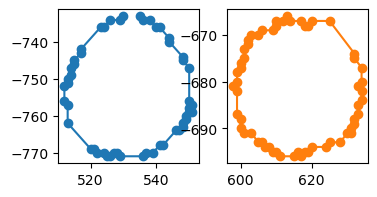

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].plot(cells[2][:, 0], cells[2][:, 1], "C0", marker="o"); axes[1].plot(cells[3][:, 0], cells[3][:, 1], "C1", marker="o");

## Practice: SRV Quotient Analysis

### Recall: Procrustes Analysis

$\color{#EF5645}{\text{Definition}}$: _Procrustes Analysis_ is a general method to perform machine learning on shapes of objects defined by sets of landmarks $X_0, ..., X_n$.

1. Superimpose objects $X_0, ..., X_n$: translate, rotate, possibly scale.

- This step sends the objects in a _Kendall shape space_, where we have the `KendallShapeMetric`.

<center><img src="figs/02_procrustes.png" width=900px alt="default"/></center>

2. Perform machine learning on superimposed objects (shapes).


$\rightarrow$ Quotient SRV Analysis is an equivalent of Procrustes analysis for curves.

### Difference between size of landmarks and length of curves

Take $X^{(l)}$ the $l$-th landmark in set $X$, or the $l$-th sampling point in curve $X$.

The definition of barycenter is the same for a set of landmarks and for a curve.

$\color{#EF5645}{\text{Definition}}$: The _barycenter $\bar X$_ of $X$ is $\bar X = \frac{1}{k} \sum_{l=1}^k X^{(l)}$. We say that $X$ is centered if its barycenter is at $0$.

The definition of size differs for a set of landmarks and for a curve.

$\color{#EF5645}{\text{Definitions}}$:
- The _size $s$_ of a *centered* set of landmarks is $s = \sqrt{\sum_{l=1}^k ||X^{(l)}||^2}$. 
- The _size $s$_ of a *centered* curve is its length $s = \sum_{l=1}^{k-1} ||X^{(l+1)} - X^{(l)}||$. 

### Today: SRV Quotient Analysis

$\color{#EF5645}{\text{Definition}}$: _SRV Quotient Analysis_ is a general method to perform machine learning on shapes of objects defined by discrete curves $X_0, ..., X_n$.

1. Superimpose objects $X_0, ..., X_n$: translate, rotate, possibly scale, and reparameterize.

- This step sends the objects in a _SRV quotient space_, where we have the `SRVQuotientMetric`.


<center><img src="figs/02_procrustes.png" width=900px alt="default"/></center>

2. Perform machine learning on superimposed objects (shapes).

### 1. Superimpose objects $X_0, ..., X_n$: translate, rotate, possibly scale, and reparameterize.

$\color{#EF5645}{\text{Theory}}$: Fix a $X_0$. For each $i=1, ..., n$: 
- Find $g_i \in G$, such that: $g_i = \text{argmin}_{g \in G} ||X_0 - g \ast X_i||^2,$ where:
  - $G$ represents the group of rotations, translations, possibly scalings, and reparameterizations.
  - $g \ast X$ represents the "action" of $g$ on the curve $X$.
- Use this $g_i$ to superimpose $X_i$ onto $X_0$ by computing $g_i \ast X_i$.

$\color{#EF5645}{\text{Practice}}$:
- Projection: Superimposing with translations and rescalings amounts to "project" the $X$'s in a "preshape space".
  - $X$ is translated such that its barycenter is at 0.
  - $X$ is re-scaled such that its length is 1.
- Orientation: Superimposing with rotations amounts to "align" the preshapes and send them into a "shape bundle".
- Parameterization: Superimposing with paramterizations amounts to "align" and send the data into a "SRV quotient space".

$\rightarrow$ Use methods `projection`, rescale manually for the length, `align` of the manifold `PreShapeSpace`, `align` of the manifold `SRVShapeBundle`.

$\color{#EF5645}{\text{Python}}$:

Create two parameterized curves in the 2D Euclidean plane $\mathbb{R}^2$.

In [34]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves

r2 = Euclidean(dim=2); curves_r2 = DiscreteCurves(ambient_manifold=r2)

parametrized_curve_a = lambda x: np.transpose(
    np.array([1 + 2 * np.sin(np.pi * x), 3 + 2 * np.cos(np.pi * x)]) / (2*np.pi))
parametrized_curve_b = lambda x: np.transpose(
    np.array([5 * np.ones(len(x)), 4 * (1 - x) + 1]) / 4)
k_sampling_points = 41; sampling_points = np.linspace(0.0, 1.0, k_sampling_points)
curve_a = parametrized_curve_a(sampling_points)
curve_b = parametrized_curve_b(sampling_points)

Visualize the curves.

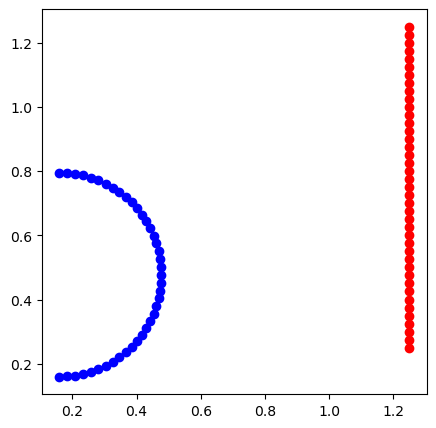

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(curve_a[:, 0], curve_a[:, 1], "o-b")
ax.plot(curve_b[:, 0], curve_b[:, 1], "o-r")
ax.set_aspect('equal');

Get the manifolds required to perform the superimposition.

Get the function computing a length.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.geometry.discrete_curves import SRVShapeBundle

preshape = PreShapeSpace(m_ambient=2, k_landmarks=k_sampling_points)
shape_bundle = SRVShapeBundle(ambient_manifold=r2, k_sampling_points=k_sampling_points)

def curve_length(curve):
    return sum([
        np.linalg.norm(curve[l+1] - curve[l]) 
        for l in range(0, k_sampling_points-1)
               ])

Superimpose the curves in translation, scaling, rotation and parameterization.

In [56]:
# Translation
curve_a = preshape.projection(curve_a); curve_b = preshape.projection(curve_b)
print("Barycenters:", np.mean(curve_a, axis=0), np.mean(curve_b, axis=0))
# Scaling
curve_a = 1 / curve_length(curve_a) * curve_a; curve_b = 1 / curve_length(curve_b) * preshape.projection(curve_b)
print("Lengths:", curve_length(curve_a), curve_length(curve_b))
# Rotation
curve_b = preshape.align(curve_b, base_point=curve_a)
# Parameterization
# curve_b = shape_bundle.align(curve_b, base_point=curve_a)

Barycenters: [3.38482629e-19 6.76965259e-19] [-1.50316483e-34  1.35393052e-17]
Lengths: 1.0000000000000004 0.9999999999999997


Visualize the curves after superimposition.

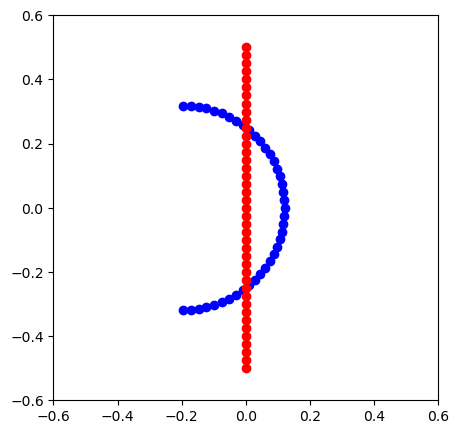

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(curve_a[:, 0], curve_a[:, 1], "o-b")
ax.plot(curve_b[:, 0], curve_b[:, 1], "o-r")
ax.set_aspect('equal'); ax.set_ylim((-0.6, 0.6)); ax.set_xlim((-0.6, 0.6));

### 2. Perform machine learning on superimposed objects (shapes).

= amounts to perform statistics in the "SRV Quotient space".

The SRV Quotient space is a manifold equipped with a Riemannian metric called the SRV Quotient metric.

We can use this metric to run machine learning algorithms (see Unit 3).

$\color{#EF5645}{\text{Remark}}$: The SRV quotient metric re-orient and re-parameterizes its curves before performing its computations.

In [58]:
from geomstats.geometry.discrete_curves import SRVQuotientMetric

srv_quotient_metric = SRVQuotientMetric(
    ambient_manifold=r2, 
    k_sampling_points=k_sampling_points)

## Theory: SRV Quotient Space

### SRV Transform

We will present the theory for continuous curves.

$\color{#EF5645}{\text{Definition}}$: Let $s$ be a parameterized surface $s: D\rightarrow \mathbb{R}^{3}$.

- Consider the mapping $F: \mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$ such that: $F(v) \equiv v / \sqrt{\|v\|}$, if $\|v\| \neq 0$ and 0 otherwise. 

The Square-Root Velocity transform of a curve $\beta$ is defined as $q: [0, 1] \rightarrow \mathbb{R}^{m}$, where
$$
q(t) \equiv F(\dot{\beta}(t))=\dot{\beta}(t) / \sqrt{\|\beta(\dot{t})\|}
$$


### SRV Transform and Translations

_What happened when we removed the translation?_

$\color{#6D7D33}{\text{Property}}$: The SRV transform $q$ is independent of the position of the curve $\beta$, i.e. it naturally removes the translation (we did not have to do it manually).

<center><img src="figs/02_srv2.svg" width=800px alt="default"/></center>


### Insights on Translations

$\color{#EF5645}{\text{Proposition}}$: For every $q \in \mathbb{L}^{2}\left([0, 1], \mathbb{R}^{m}\right)$, there exists a curve $\beta$ (unique up to a translation) such that the given $q$ is the SRV function of that $\beta$. 

This curve is obtained as: $\beta(t)=\int_{0}^{t} q(s)\|q(s)\| d s$.

<center><img src="figs/02_srv_inverse2.svg" width=600px alt="default"/></center>

### SRV Transform and Scaling

_What happened when we removed the scaling, i.e. when we rescale the curves to be of unit length?_

$\color{#6D7D33}{\text{Property}}$: The restriction that $\beta$ is of unit length: $L(\beta)=\int_{[0, 1]}\|\dot{\beta}\| d t=1$ translates into a restriction on its SRV transform $q$: $\int_{[0, 1]}\|q(t)\|^{2} d t=1.$


<center><img src="figs/02_srv_spaces.svg" width=900px alt="default"/></center>

### PreShape space

Rescaling the curve $\beta$ assigns its SRV $q$ to an hypersphere in $L([0, 1], \mathbb{R}^2)$.

- Similar to what happened in Kendall shape spaces, even though the notion of "size" is different.
- Except that the hypersphere is within a infinite dimensional space: $L([0, 1], \mathbb{R}^2)$, which makes sense since a continuous curve has an infinite number of landmarks.

$\color{#EF5645}{\text{Definition}}$: The hypersphere $S$ in $L([0, 1], \mathbb{R}^2)$ defined by $\int_{[0, 1]}\|q(t)\|^{2} d t=1$ is called the preshape space for continuous (open) curves.

### SRV Transform and Rotations

_What happened when we removed the rotation?_

$\color{#6D7D33}{\text{Property}}$: Finding the optimal rotation aligning curves $\beta_a, \beta_b$ is equivalent to finding the optimal rotation aligning their SRV transforms $q_a, q_b$.

$\color{#047C91}{\text{Exercise}}$: Prove the above by showing that a 2D rotation $R \in SO(2)$ rotating a curve $\beta$ is equivalently rotating its SRV: $q(R.\beta) = R. q(\beta).$


<center><img src="figs/02_orbits_sphere.png" width=300px alt="default"/></center>
<center>Schematic illustration of the orbits of $SO(2)$ on the preshape (infinite dimensional) hypersphere, represented as orbits of $SO(2)$ on the 2D sphere for convenience.</center>

### SRV Transform and Reparameterization

_How do we remove the reparameterization?_

$\color{#6D7D33}{\text{Property}}$: Denote $\Gamma$ the (infinite dimensional) Lie group of reparameterization of $[0, 1]$. Changing the parameterization of the curve $\beta$ by applying $\beta \circ \gamma$ for $\gamma \in \Gamma$ is equivalent to changing its SRV as $(q \circ \gamma) \sqrt{\dot{\gamma}}$.


$\color{#EF5645}{\text{Remark}}$: This is harder to visualize, because $\Gamma$ is infinite dimensional.

<center><img src="figs/02_orbits_sphere.png" width=300px alt="default"/></center>
<center>Schematic illustration of the orbits of $\Gamma$ on the preshape (infinite dimensional) hypersphere, represented as orbits of $SO(2)$ on the 2D sphere for convenience.</center>

### What is the "SRV Quotient "?


$\color{#EF5645}{\text{Definition}}$: The SRV quotient space $\mathcal{Q}$ is the preshape space of curves $S$ for which the action of the rotations and the reparameterization have been removed together. 

The geodesic distance between any two elements $\tilde q_a, \tilde q_b$ in the quotient SRV space $\mathcal{Q}$ is given by the distance between the optimally aligned elements $q_a, q_b$ of the preshape space $S$.
$$
d_{Q}\left(\tilde q_a,\tilde q_b\right)=\inf _{(\gamma, R) \in \Gamma \times SO(2)} d_{S}\left(q_{a}, R\left(q_{b} \circ \gamma\right) \sqrt{\dot{\gamma}}\right)
$$

$\color{#EF5645}{\text{Remark}}$: Using the quotient SRV metric actually removes rotation and reparameterization at once!

## Application: Understanding Cancer Treatments

In [32]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = np.array(output_list)
    return output_ds

In [33]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = np.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(np.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


N_SAMPLING_POINTS = 200

In [35]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=N_SAMPLING_POINTS)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_metric


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = np.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=reparametrized, base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(
            np.array(aligned) - np.array(base_curve)
        )
    shift_min = np.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.align(
        point=reparametrized_min, base_point=base_curve
    )
    return aligned_curve

1. Perform an equivalent of Procrustes Analysis.

In [36]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, N_SAMPLING_POINTS)
)
BASE_CURVE = ds_interp["control"]["dlm8"][0]
ds_proj = apply_func_to_ds(ds_interp, func=PRESHAPE_SPACE.projection)
ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
ds_oriented = apply_func_to_ds(ds_align, func=lambda x: PRESHAPE_SPACE.align(x, BASE_CURVE))

print(ds_oriented["control"]["dlm8"].shape)

(114, 200, 2)


2. Perform statistical analysis.

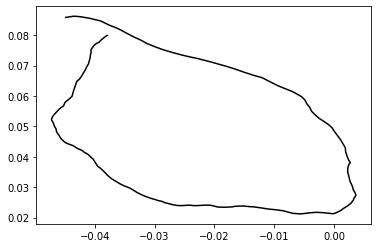

In [41]:
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(metric=metric, point_type="matrix", method="default")
mean.fit(ds_oriented["cytd"]["dunn"])

mean_estimate = mean.estimate_
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

<center><img src="figs/02_cells_quantiles.png" width=1200px alt="default"/></center>

# Outline

- **Unit 2 (Shapes): Computational Representations of Biomedical Shapes**
  - A) Shapes of landmarks
  - **B) Shapes of curves**
    - Motivation: Shape of Cancer Treatments
    - Practice: SRV Quotient Analysis
    - Theory: Geometry of SRV manifolds
    - Application: Osteoscarcoma cells
  - C) Shapes of surfaces
  - D) Deformations